**CV2021- Week 10**

**Contents**
* [CamShift tracking](https://colab.research.google.com/drive/1_cNfArvzAaldNkQRY65Nea9AnA7m9FlX#scrollTo=H6fHl9X1cJw3&line=4&uniqifier=1)
* [Perceptrons for classification](https://colab.research.google.com/drive/1_cNfArvzAaldNkQRY65Nea9AnA7m9FlX#scrollTo=NhvcPPyzodRb&line=2&uniqifier=1)
* [Feature extraction by multi-layer Perceptrons](https://colab.research.google.com/drive/1_cNfArvzAaldNkQRY65Nea9AnA7m9FlX#scrollTo=nks336kjOhSt&line=1&uniqifier=1)
* [Regularization and overfitting](https://colab.research.google.com/drive/1_cNfArvzAaldNkQRY65Nea9AnA7m9FlX#scrollTo=2VwSFgS0SF8o&line=2&uniqifier=1)
* [Image compression by Auto-Encoders](https://colab.research.google.com/drive/1_cNfArvzAaldNkQRY65Nea9AnA7m9FlX#scrollTo=04WeDjmdeNNx&line=1&uniqifier=1)

**HOMEWORK**

* **1bp** Implement a version of *Grid Search Cross Validation* to search for the best combination of hyperparameters and callbacks, optimizing the classification stage for the EFD-MNIST dataset. Report your results comparing the best three models.

* **1bp** Using the *Cross Validation* procedure, determine the best architecture format for the Multi-Layer Perceptron model. Compute the number of parameters of the model.

* **1bp** Compare the Auto-Encoder learnt representation to the EFD fitted classifiers from *week 8*. Is the autoencoder able to learn a better representation? Discuss your results.


**1. CamShift tracking**

**References**
* [OpenCV Tutorial](https://docs.opencv.org/3.4/d7/d00/tutorial_meanshift.html)
* [Our results](https://drive.google.com/drive/folders/10k7wQp-KlyJR32u38f3JBST17eMTqTtM?usp=sharing)

In [6]:
import cv2 as cv
import numpy as np


video_capture = cv.VideoCapture("/content/drive/MyDrive/CVCourse21/pics/sample_video.avi")
out_dir = '/content/drive/MyDrive/CVCourse21/camshift_demo'


ret_cap, frame = video_capture.read()
print(frame.shape)

# initialize window for face
x, y, w, h = (100, 45, 25, 30)
track_window = (x, y, w, h)

# set the region of interest (ROI)
roi = frame[y: y+h, x: x+w]
roi_hsv = cv.cvtColor(roi, cv.COLOR_BGR2HSV)
mask = cv.inRange(roi_hsv, np.array((0., 60.,32.)), np.array((180.,255.,255.)))

roi_hist = cv.calcHist([roi_hsv],[0],mask,[180],[0,180])
cv.normalize(roi_hist, roi_hist, 0, 255, cv.NORM_MINMAX)



# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )


fnums = []
x_s = []
y_s = []
ret = True
fnum = 0

while True:
  ret_cap, frame = video_capture.read()
  fnum += 1

  if ret_cap == False:
    break
  
  hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
  dst = cv.calcBackProject([hsv], [0], roi_hist, [0,180], 1) # find the best batching displacement
  ret, track_window = cv.CamShift(dst, track_window, term_crit) # use camshift based on the displacement
  x,y,w,h = track_window

  pts = np.int0(cv.boxPoints(ret))
  center = np.mean(pts, axis=0)
  plot_img = frame.copy()

  x_s.append(center[0])
  y_s.append(center[1])
  plot_img = cv.polylines(plot_img, [pts], True, 255, 2)

  fnums.append(fnum)
  cv.imwrite("{}/{}.png".format(out_dir, str(fnum - 1).zfill(3)), plot_img)

(120, 160, 3)


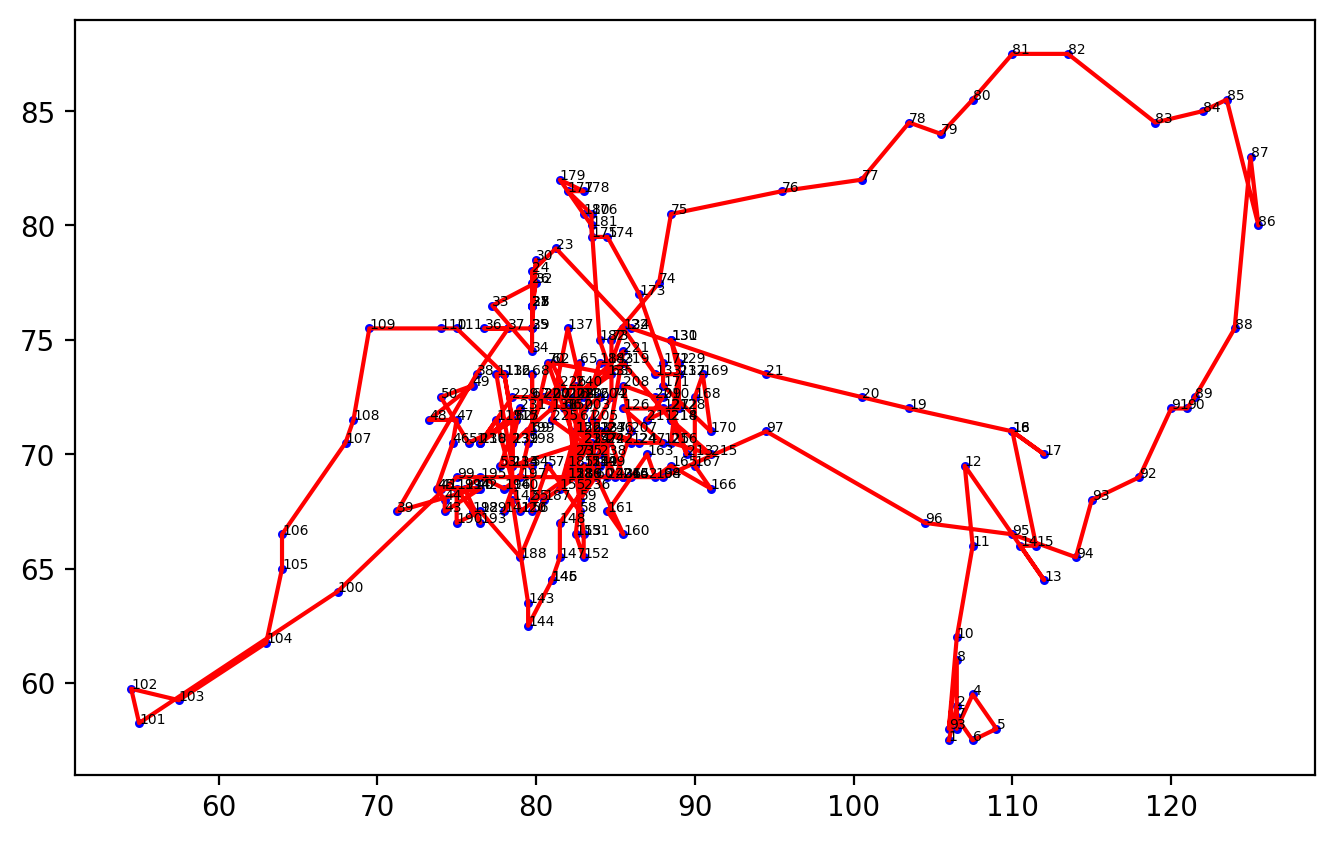

In [7]:
# plot trajectory
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 200

plt.scatter(x_s, y_s, s=5, c='blue')
plt.plot(x_s, y_s, c='red')
for i, fnum in enumerate(fnums):
  plt.annotate(str(fnum), (x_s[i], y_s[i]), fontsize=5)

**2. Perceptrons as classifiers**

In this task, we will reuse the data processing pipeline with Elliptical Fourier Descriptors, but the particular choice for the classifier will be a single perceptron, as presented in the lecture material.

**References**
* [About EFD](https://github.com/hbldh/pyefd)
* [Keras classification introduction](https://www.tensorflow.org/tutorials/keras/classification)
* [Used dataset](https://drive.google.com/drive/folders/1rPxI83BSdDqKNMjBXX1JRezk-DRYEI7M?usp=sharing)

In [8]:
! pip install pyefd

In [13]:
import os
from pyefd import elliptic_fourier_descriptors



def load_dataset(dset_dir):
  # a dict to keep the class of each image
  image_index = {}

  for class_name in os.listdir(dset_dir):
    in_cat_images = []
    cat_dir_path = "{}/{}".format(dset_dir, class_name)
    for file_name in os.listdir(cat_dir_path):
      img_path = "{}/{}".format(cat_dir_path, file_name)
      img = cv.imread(img_path, 0) # open as grayscale
      if img is not None: # unless some corrupted images
        in_cat_images.append(img)
    image_index[class_name] = in_cat_images
  
  return image_index


def extract_efd_feature(img):
  contours, _ = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  fd = []
  for cnt in contours:
    coeffs = elliptic_fourier_descriptors(np.squeeze(cnt), order=10, normalize=True)
    fd.append(coeffs.flatten()[3:])
  return np.array(fd)


def prepare_data(image_set):
  X = []
  Y = []
  for img_class, img_list in image_set.items():
    for image in img_list:
      try:
        fdesc = extract_efd_feature(image)
        X.append(np.max(fdesc, axis=0)) 
        Y.append(int(img_class))
      except np.AxisError:
        continue # some corrupted images

  return np.array(X), np.array(Y)

In [14]:
train_img = load_dataset("/content/drive/MyDrive/CVCourse21/mnist_png_demo/training/")
val_img = load_dataset("/content/drive/MyDrive/CVCourse21/mnist_png_demo/validation/")
test_img = load_dataset("/content/drive/MyDrive/CVCourse21/mnist_png_demo/testing/")

X_train, Y_train = prepare_data(train_img)
X_val, Y_val = prepare_data(val_img)
X_test, Y_test = prepare_data(test_img)

In [42]:
from keras.callbacks import Callback


class ValidationCallback(Callback):
  def __init__(self, train_data, validation_data, test_data, verbose=False):
    self.train_data = train_data
    self.validation_data = validation_data
    self.test_data = test_data
    self.train_log = {}
    self.val_log = {}
    self.test_log = {}
    self.verbose = verbose

  def on_epoch_end(self, epoch, logs={}):
    x_train, y_train = self.train_data
    x_val, y_val = self.validation_data
    x_test, y_test = self.test_data

    train_loss, train_acc = self.model.evaluate(x_train, y_train, verbose=0)
    val_loss, val_acc = self.model.evaluate(x_val, y_val, verbose=0)
    test_loss, test_acc = self.model.evaluate(x_test, y_test, verbose=0)

    self.train_log[epoch] = train_acc
    self.val_log[epoch] = val_acc
    self.test_log[epoch] = test_acc

    if self.verbose == True:
      log = 'E: {} - Train - Val - Test loss: {} - {} - {}, acc: {} - {} - {}'.format(
              epoch, train_loss, val_loss, test_loss, train_acc, val_acc, test_acc)
      print(log)

In [64]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(10))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

callbacks = [ValidationCallback((X_train, Y_train), (X_val, Y_val), (X_test, Y_test))]
model.fit(X_train, Y_train, epochs=60, callbacks=callbacks, verbose=0)



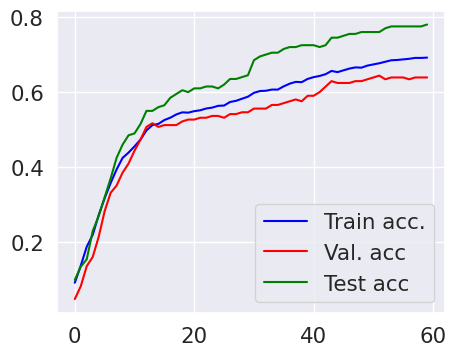

In [65]:
cb = callbacks[0]
plt.plot(list(cb.train_log.keys()), list(cb.train_log.values()), label='Train acc.', c='blue')
plt.plot(list(cb.val_log.keys()), list(cb.val_log.values()), label='Val. acc', c='red')
plt.plot(list(cb.test_log.keys()), list(cb.test_log.values()), label='Test acc', c='green')
plt.legend()

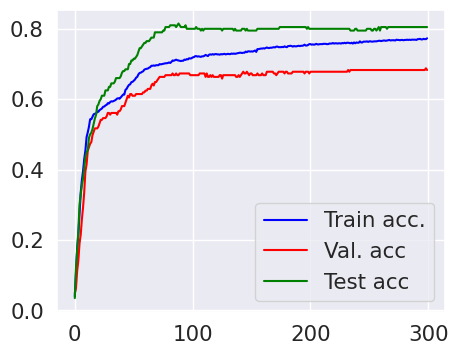

In [66]:
# now, let's evaluate the behaviour of our model for after more epochs

model = Sequential()
model.add(Dense(10))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


callbacks = [ValidationCallback((X_train, Y_train), (X_val, Y_val), (X_test, Y_test))]
model.fit(X_train, Y_train, epochs=300, callbacks=callbacks, verbose=0)

cb = callbacks[0]
plt.plot(list(cb.train_log.keys()), list(cb.train_log.values()), label='Train acc.', c='blue')
plt.plot(list(cb.val_log.keys()), list(cb.val_log.values()), label='Val. acc', c='red')
plt.plot(list(cb.test_log.keys()), list(cb.test_log.values()), label='Test acc', c='green')
plt.legend()


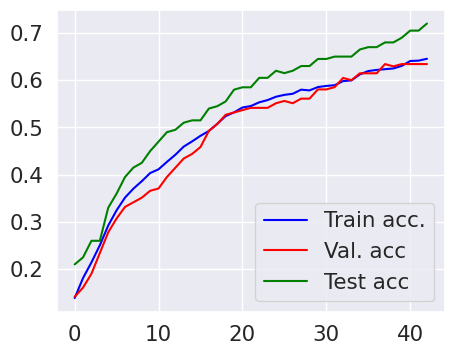

In [67]:
# now, let's find the best number of epochs to train this model

model = Sequential()
model.add(Dense(10))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


callbacks = [tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy', patience=5, verbose=0),
             ValidationCallback((X_train, Y_train), (X_val, Y_val), (X_test, Y_test))]
model.fit(X_train, Y_train, epochs=300, validation_data=(X_val, Y_val), callbacks=callbacks, verbose=0)

cb = callbacks[1]
plt.plot(list(cb.train_log.keys()), list(cb.train_log.values()), label='Train acc.', c='blue')
plt.plot(list(cb.val_log.keys()), list(cb.val_log.values()), label='Val. acc', c='red')
plt.plot(list(cb.test_log.keys()), list(cb.test_log.values()), label='Test acc', c='green')
plt.legend()

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


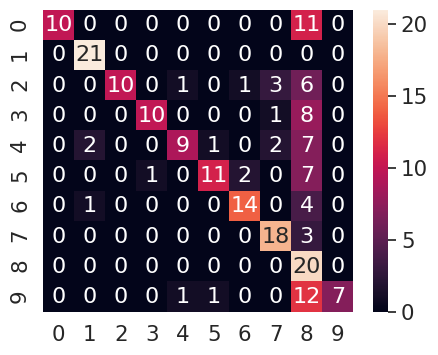

In [68]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix

plt.rcParams['figure.figsize'] = [5, 4]
plt.rcParams['figure.dpi'] = 100

predictions = model.predict_classes(X_val, verbose=0)

clf_confusion_matrix = confusion_matrix(Y_val, predictions)
classes = [str(i) for i in range(10)]
df_cmatrix = pd.DataFrame(clf_confusion_matrix, classes, classes)
sn.set(font_scale=1.4) 
sn.heatmap(df_cmatrix, annot=True, annot_kws={"size": 16})


Epoch 1/300
40/40 [==============================] - 1s 8ms/step - loss: 2.3419 - accuracy: 0.0433 - val_loss: 2.3233 - val_accuracy: 0.0537
Epoch 2/300
40/40 [==============================] - 0s 2ms/step - loss: 2.3158 - accuracy: 0.0805 - val_loss: 2.2989 - val_accuracy: 0.1268
Epoch 3/300
40/40 [==============================] - 0s 2ms/step - loss: 2.2841 - accuracy: 0.1602 - val_loss: 2.2755 - val_accuracy: 0.1707
Epoch 4/300
40/40 [==============================] - 0s 3ms/step - loss: 2.2569 - accuracy: 0.2171 - val_loss: 2.2532 - val_accuracy: 0.1951
Epoch 5/300
40/40 [==============================] - 0s 2ms/step - loss: 2.2324 - accuracy: 0.2325 - val_loss: 2.2318 - val_accuracy: 0.2293
Epoch 6/300
40/40 [==============================] - 0s 2ms/step - loss: 2.2109 - accuracy: 0.2634 - val_loss: 2.2111 - val_accuracy: 0.2683
Epoch 7/300
40/40 [==============================] - 0s 2ms/step - loss: 2.1893 - accuracy: 0.2893 - val_loss: 2.1913 - val_accuracy: 0.3024
Epoch 8/300
4

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 2ms/step


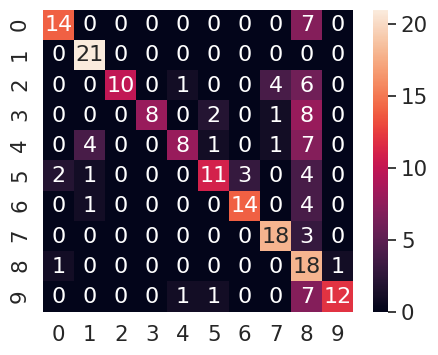

In [70]:
# use the restore_best_params feature

model = Sequential()
model.add(Dense(10))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              restore_best_weights=True, 
                                              patience=5, verbose=0),
             ValidationCallback((X_train, Y_train), (X_val, Y_val), (X_test, Y_test))]
model.fit(X_train, Y_train, epochs=300, validation_data=(X_val, Y_val), callbacks=callbacks, verbose=1)
predictions = model.predict_classes(X_val, verbose=1)

clf_confusion_matrix = confusion_matrix(Y_val, predictions)
classes = [str(i) for i in range(10)]
df_cmatrix = pd.DataFrame(clf_confusion_matrix, classes, classes)
sn.set(font_scale=1.4) 
sn.heatmap(df_cmatrix, annot=True, annot_kws={"size": 16})


7/7 [==============================] - 0s 2ms/step


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


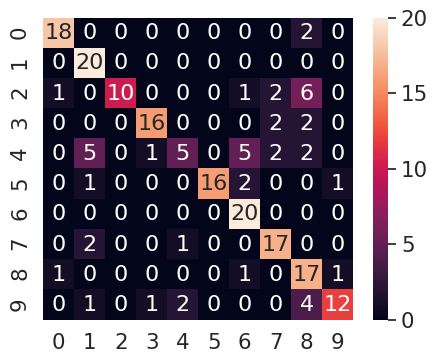

In [71]:
# compute test split predictions and plot conf matrix
predictions = model.predict_classes(X_test, verbose=1)

clf_confusion_matrix = confusion_matrix(Y_test, predictions)
classes = [str(i) for i in range(10)]
df_cmatrix = pd.DataFrame(clf_confusion_matrix, classes, classes)
sn.set(font_scale=1.4) 
sn.heatmap(df_cmatrix, annot=True, annot_kws={"size": 16})


In [ ]:
Precision = TP / (TP + FP)

1. = 20 / (20 + ) = 0.8

2. = 10/(10) = 1

5. = 16 / (16 + 0) = .1

8. = 17 / (17 + 14) = .54


**3. Feature extraction in MLP**

In [1]:
import tensorflow.keras.datasets as datasets
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten

(X_train, Y_train), (X_test, Y_test) = datasets.mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [23]:
print(X_train.shape) # 60000 28 x 28 images
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [22]:
# now, we will define a multi-layer perceptron for this task
# as the data is 2d, we will start by flattening it

layers = [64, 32, 16]

model = Sequential()
model.add(Flatten())

# now, let's add a sequence of Dense layers, based on ReLU activation
for sz in layers:
  model.add(Dense(sz, activation='relu'))

model.add(Dense(10)) # the definition of the classifier stage will be the same
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# fit the model keeping 20% of the training data for validation
model.fit(X_train, Y_train, epochs=15, validation_split=0.2, verbose=1)
predictions = model.predict_classes(X_test, verbose=1)

print("Classification accuracy: {}".format(accuracy_score(Y_test, predictions)))

Epoch 1/15
1500/1500 [==============================] - 6s 3ms/step - loss: 2.9852 - accuracy: 0.3210 - val_loss: 0.9236 - val_accuracy: 0.7318
Epoch 2/15
1500/1500 [==============================] - 5s 3ms/step - loss: 0.8519 - accuracy: 0.7380 - val_loss: 0.4953 - val_accuracy: 0.8808
Epoch 3/15
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4748 - accuracy: 0.8821 - val_loss: 0.4128 - val_accuracy: 0.9035
Epoch 4/15
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3313 - accuracy: 0.9202 - val_loss: 0.3018 - val_accuracy: 0.9209
Epoch 5/15
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2479 - accuracy: 0.9393 - val_loss: 0.2402 - val_accuracy: 0.9466
Epoch 6/15
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1926 - accuracy: 0.9504 - val_loss: 0.2294 - val_accuracy: 0.9476
Epoch 7/15
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1595 - accuracy: 0.9581 - val_loss: 0.2063 - val_accuracy:

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


313/313 [==============================] - 1s 1ms/step
Classification accuracy: 0.9597


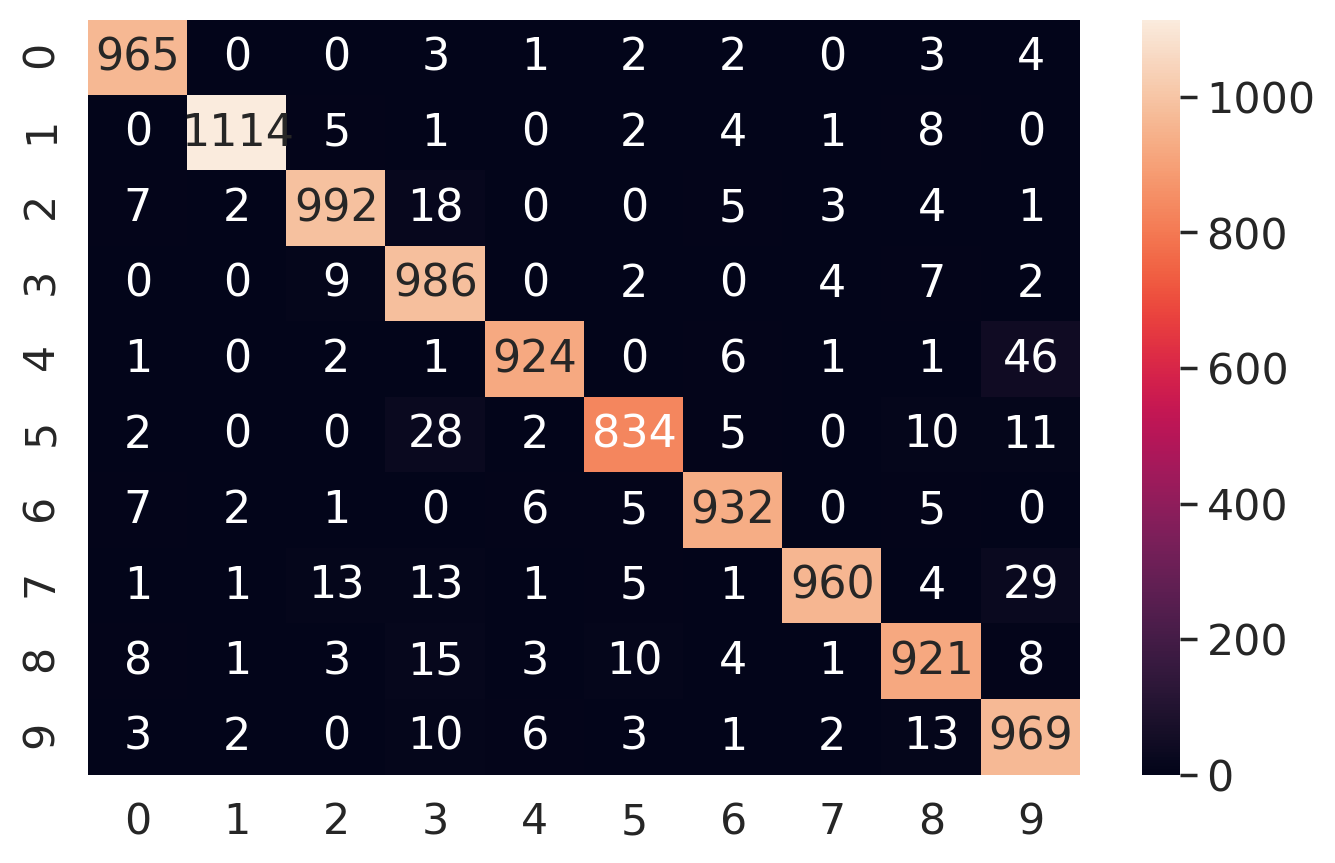

In [27]:
clf_confusion_matrix = confusion_matrix(Y_test, predictions)
classes = [str(i) for i in range(10)]

df_cmatrix = pd.DataFrame(clf_confusion_matrix, classes, classes)
df_cmatrix.style.format("{:.1f}")


sn.set(font_scale=1.4) 
sn.heatmap(df_cmatrix, annot=True, annot_kws={"size": 16}, fmt='g')

**4. Regularization and overfitting**


In [28]:
# Firstly, we need a callback to observer the behaviour of the model on test data
# after a large number of epochs

from keras.callbacks import Callback


class TestCallback(Callback):
  def __init__(self, train_data, test_data, verbose=False):
    self.train_data = train_data
    self.test_data = test_data

    self.train_log = {}
    self.test_log = {}
    self.verbose = verbose

  def on_epoch_end(self, epoch, logs={}):
    x_train, y_train = self.train_data
    x_test, y_test = self.test_data

    train_loss, train_acc = self.model.evaluate(x_train, y_train, verbose=0)
    test_loss, test_acc = self.model.evaluate(x_test, y_test, verbose=0)

    self.train_log[epoch] = train_acc
    self.test_log[epoch] = test_acc

    if self.verbose == True:
      log = 'E: {} - Train - Test loss: {} - {}, acc: {} - {}'.format(
              epoch, train_loss, test_loss, train_acc, test_acc)
      print(log)

In [29]:
layers = [64, 32, 16]

model = Sequential()
model.add(Flatten())

# now, let's add a sequence of Dense layers, based on ReLU activation
for sz in layers:
  model.add(Dense(sz, activation='relu'))

model.add(Dense(10)) # the definition of the classifier stage will be the same
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# use the callbacks to track the evolution
unreg_callbacks = [TestCallback((X_train, Y_train), (X_test, Y_test))]

# fit the model keeping 20% of the training data for validation
model.fit(X_train, Y_train, epochs=50, callbacks=unreg_callbacks, validation_split=0.2, verbose=0)
predictions = model.predict_classes(X_test, verbose=1)

print("Classification accuracy: {}".format(accuracy_score(Y_test, predictions)))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


313/313 [==============================] - 1s 1ms/step
Classification accuracy: 0.9667


In [30]:
from tensorflow.keras import regularizers

layers = [64, 32, 16]
kern_regs = [4e-4, 2e-4, 1e-4]


model = Sequential()
model.add(Flatten())

# now, let's add a sequence of Dense layers, based on ReLU activation
for sz, penalty in zip(layers, kern_regs):
  model.add(Dense(sz, activation='relu', kernel_regularizer=regularizers.l2(penalty)))

model.add(Dense(10)) # the definition of the classifier stage will be the same
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# use the callbacks to track the evolution
l2_reg_callbacks = [TestCallback((X_train, Y_train), (X_test, Y_test))]

# fit the model keeping 20% of the training data for validation
model.fit(X_train, Y_train, epochs=50, callbacks=l2_reg_callbacks, validation_split=0.2, verbose=0)
predictions = model.predict_classes(X_test, verbose=1)

print("Classification accuracy: {}".format(accuracy_score(Y_test, predictions)))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


313/313 [==============================] - 1s 1ms/step
Classification accuracy: 0.9722


In [31]:
layers = [64, 32, 16]
kern_regs = [4e-4, 2e-4, 1e-4]


model = Sequential()
model.add(Flatten())

# now, let's add a sequence of Dense layers, based on ReLU activation
for sz, penalty in zip(layers, kern_regs):
  model.add(Dense(sz, activation='relu', kernel_regularizer=regularizers.l1(penalty)))

model.add(Dense(10)) # the definition of the classifier stage will be the same
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# use the callbacks to track the evolution
l1_reg_callbacks = [TestCallback((X_train, Y_train), (X_test, Y_test))]

# fit the model keeping 20% of the training data for validation
model.fit(X_train, Y_train, epochs=50, callbacks=l1_reg_callbacks, validation_split=0.2, verbose=0)
predictions = model.predict_classes(X_test, verbose=1)

print("Classification accuracy: {}".format(accuracy_score(Y_test, predictions)))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


313/313 [==============================] - 1s 1ms/step
Classification accuracy: 0.9645


In [32]:
from keras.layers import Dropout


layers = [64, 32, 16]
dropout_rate = [0.1, 0.05, 0.05]


model = Sequential()
model.add(Flatten())

# now, let's add a sequence of Dense layers, based on ReLU activation
for sz, dp_rate in zip(layers, dropout_rate):
  model.add(Dense(sz, activation='relu'))
  model.add(Dropout(rate=dp_rate))

model.add(Dense(10)) # the definition of the classifier stage will be the same
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# use the callbacks to track the evolution
dropout_reg_callbacks = [TestCallback((X_train, Y_train), (X_test, Y_test))]

# fit the model keeping 20% of the training data for validation
model.fit(X_train, Y_train, epochs=50, callbacks=dropout_reg_callbacks, validation_split=0.2, verbose=0)
predictions = model.predict_classes(X_test, verbose=1)

print("Classification accuracy: {}".format(accuracy_score(Y_test, predictions)))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


313/313 [==============================] - 1s 1ms/step
Classification accuracy: 0.97


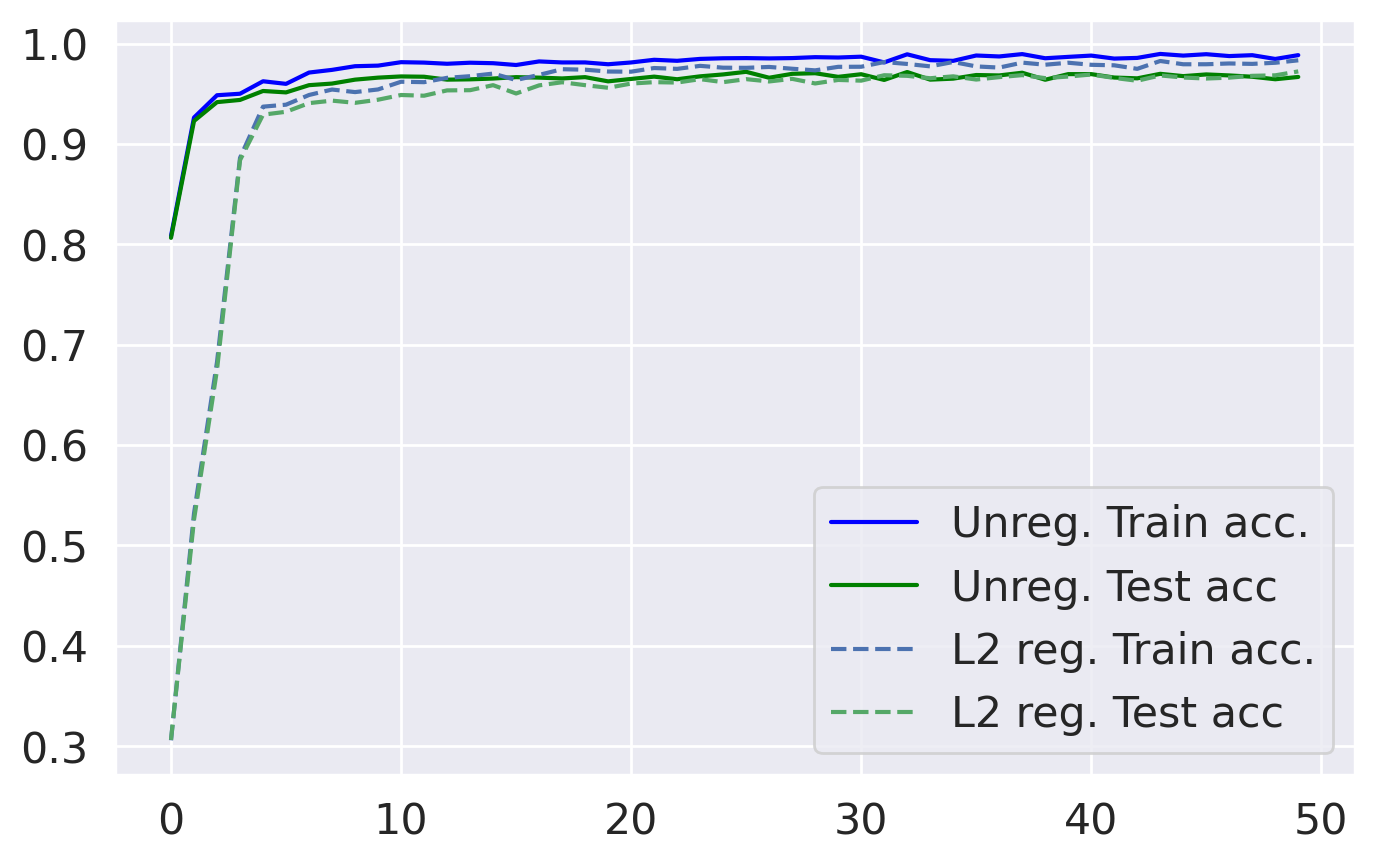

In [34]:
cb = unreg_callbacks[0]
plt.plot(list(cb.train_log.keys()), list(cb.train_log.values()), label='Unreg. Train acc.', c='blue')
plt.plot(list(cb.test_log.keys()), list(cb.test_log.values()), label='Unreg. Test acc', c='green')

cb = l2_reg_callbacks[0]
plt.plot(list(cb.train_log.keys()), list(cb.train_log.values()), 'b--', label='L2 reg. Train acc.')
plt.plot(list(cb.test_log.keys()), list(cb.test_log.values()), 'g--', label='L2 reg. Test acc')
plt.legend()

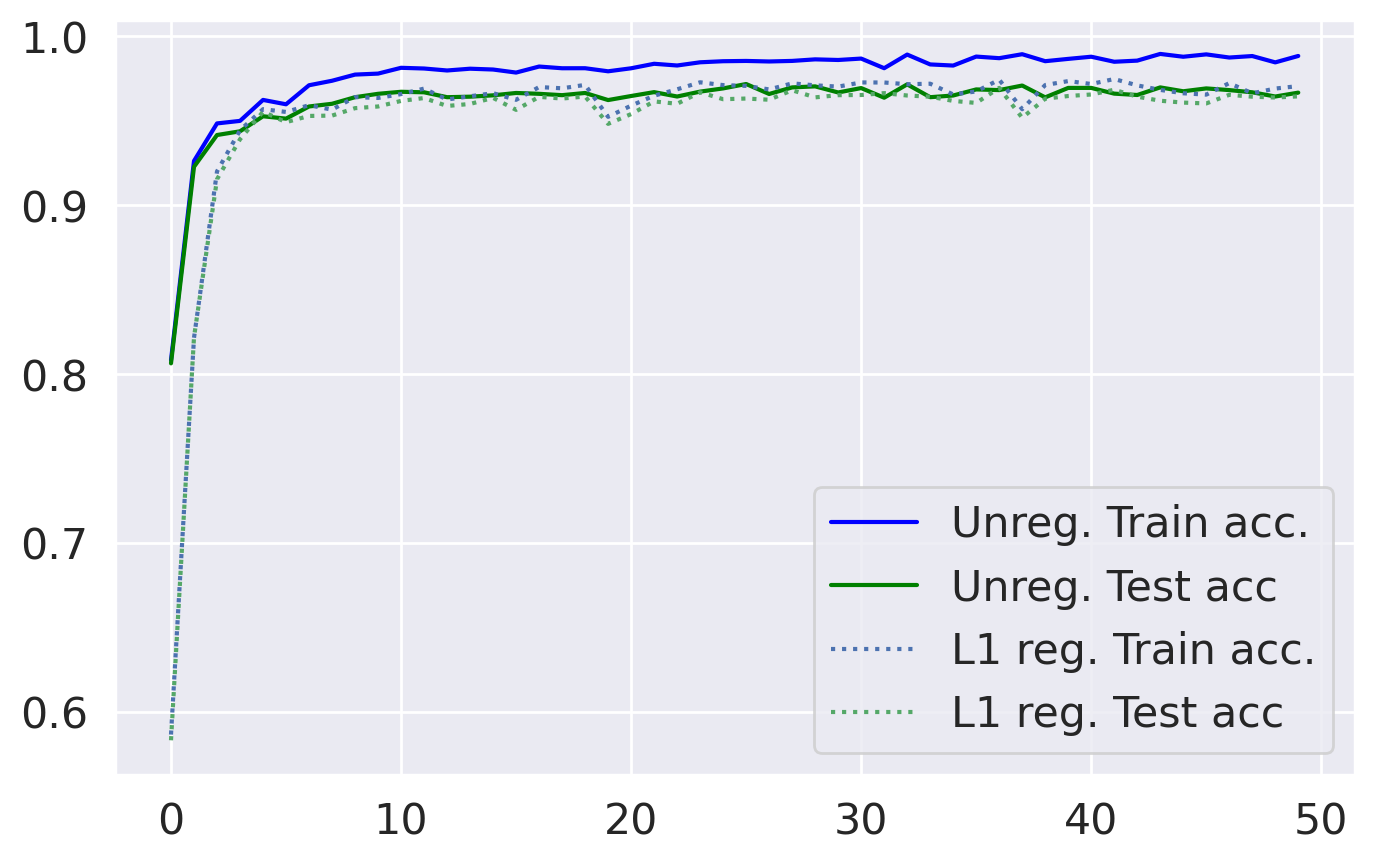

In [35]:
cb = unreg_callbacks[0]
plt.plot(list(cb.train_log.keys()), list(cb.train_log.values()), label='Unreg. Train acc.', c='blue')
plt.plot(list(cb.test_log.keys()), list(cb.test_log.values()), label='Unreg. Test acc', c='green')

cb = l1_reg_callbacks[0]
plt.plot(list(cb.train_log.keys()), list(cb.train_log.values()), 'b:', label='L1 reg. Train acc.')
plt.plot(list(cb.test_log.keys()), list(cb.test_log.values()), 'g:', label='L1 reg. Test acc')
plt.legend()

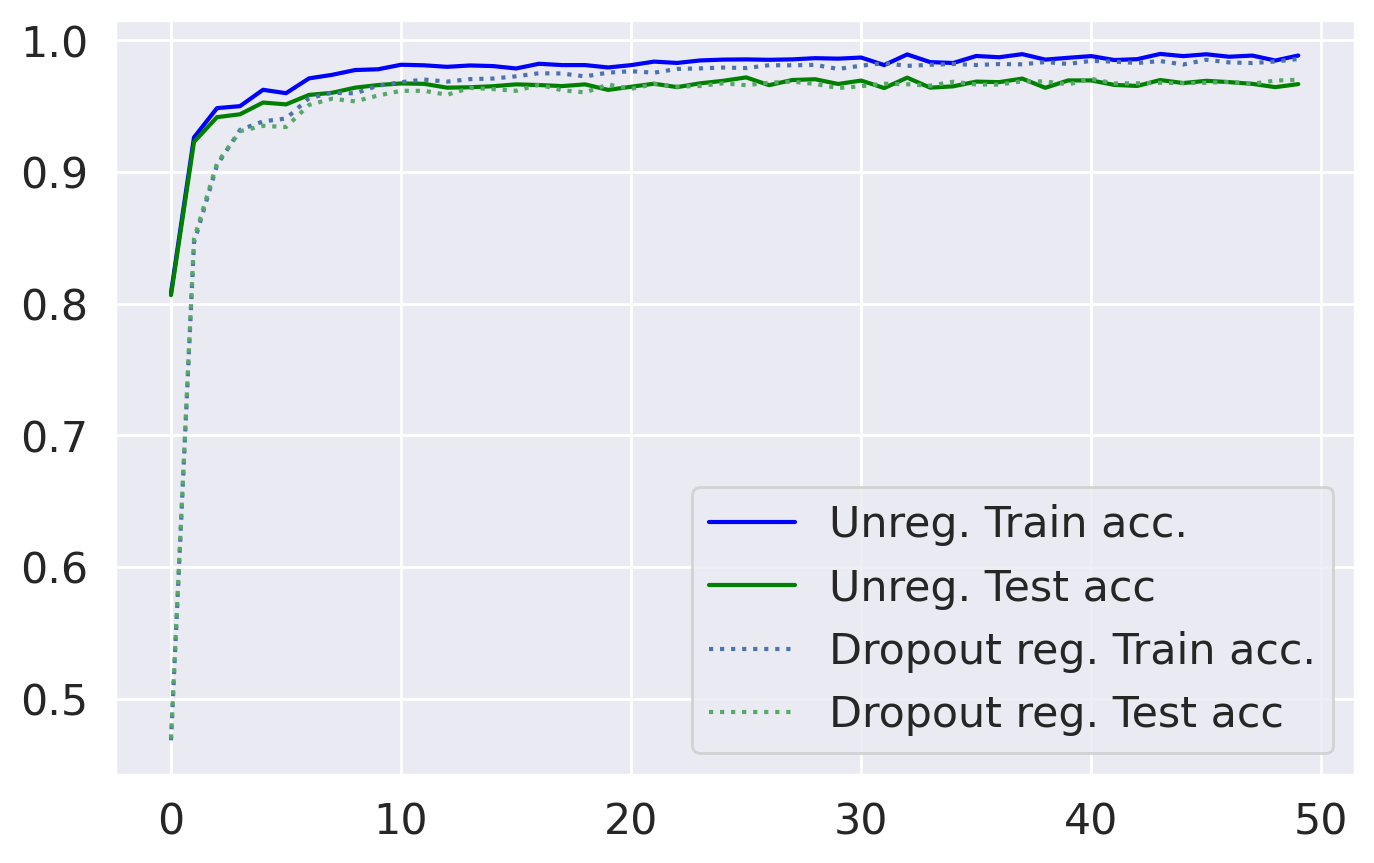

In [36]:
cb = unreg_callbacks[0]
plt.plot(list(cb.train_log.keys()), list(cb.train_log.values()), label='Unreg. Train acc.', c='blue')
plt.plot(list(cb.test_log.keys()), list(cb.test_log.values()), label='Unreg. Test acc', c='green')

cb = dropout_reg_callbacks[0]
plt.plot(list(cb.train_log.keys()), list(cb.train_log.values()), 'b:', label='Dropout reg. Train acc.')
plt.plot(list(cb.test_log.keys()), list(cb.test_log.values()), 'g:', label='Dropout reg. Test acc')
plt.legend()

**5. AutoEncoders for image representation**

**References**
* [Keras documentation](https://blog.keras.io/building-autoencoders-in-keras.html)

In [8]:
import keras
from keras import regularizers
from keras.layers import Dense

# same as the EFD descriptor
latent_dim = 37

input_flat = keras.Input(shape=(784, )) # 28 x 28
encoded = Dense(128, activation='relu')(input_flat)
encoded = Dense(64, activation='relu')(encoded)
latent = Dense(latent_dim, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(latent)
decoded = Dense(128, activation='relu')(decoded)
reconstruction = Dense(784, activation='relu')(decoded) # apply the logistic model 

autoencoder = keras.Model(input_flat, reconstruction)
autoencoder.compile(optimizer='adam', loss='mse') # mse loss between input and output

In [10]:
import numpy as np
from keras.datasets import mnist


(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)


(60000, 784)
(10000, 784)


In [11]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


Epoch 1/50
235/235 [==============================] - 2s 7ms/step - loss: 0.0611 - val_loss: 0.0272
Epoch 2/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0262 - val_loss: 0.0222
Epoch 3/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0219 - val_loss: 0.0202
Epoch 4/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0197 - val_loss: 0.0185
Epoch 5/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0185 - val_loss: 0.0177
Epoch 6/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0178 - val_loss: 0.0171
Epoch 7/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0173 - val_loss: 0.0167
Epoch 8/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0169 - val_loss: 0.0163
Epoch 9/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0165 - val_loss: 0.0163
Epoch 10/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0162 - val_loss: 0.0158

In [13]:

# now build the graphs for the encoder
encoder  = keras.Model(input_flat, latent)
X_train = encoder.predict(x_train)
X_test = encoder.predict(x_test)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 37) (60000,)
(10000, 37) (10000,)


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf =  SVC(C=1.5, kernel='rbf', gamma='auto')
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

print("Classification accuracy: {}".format(accuracy_score(y_test, predictions)))


Classification accuracy: 0.9775


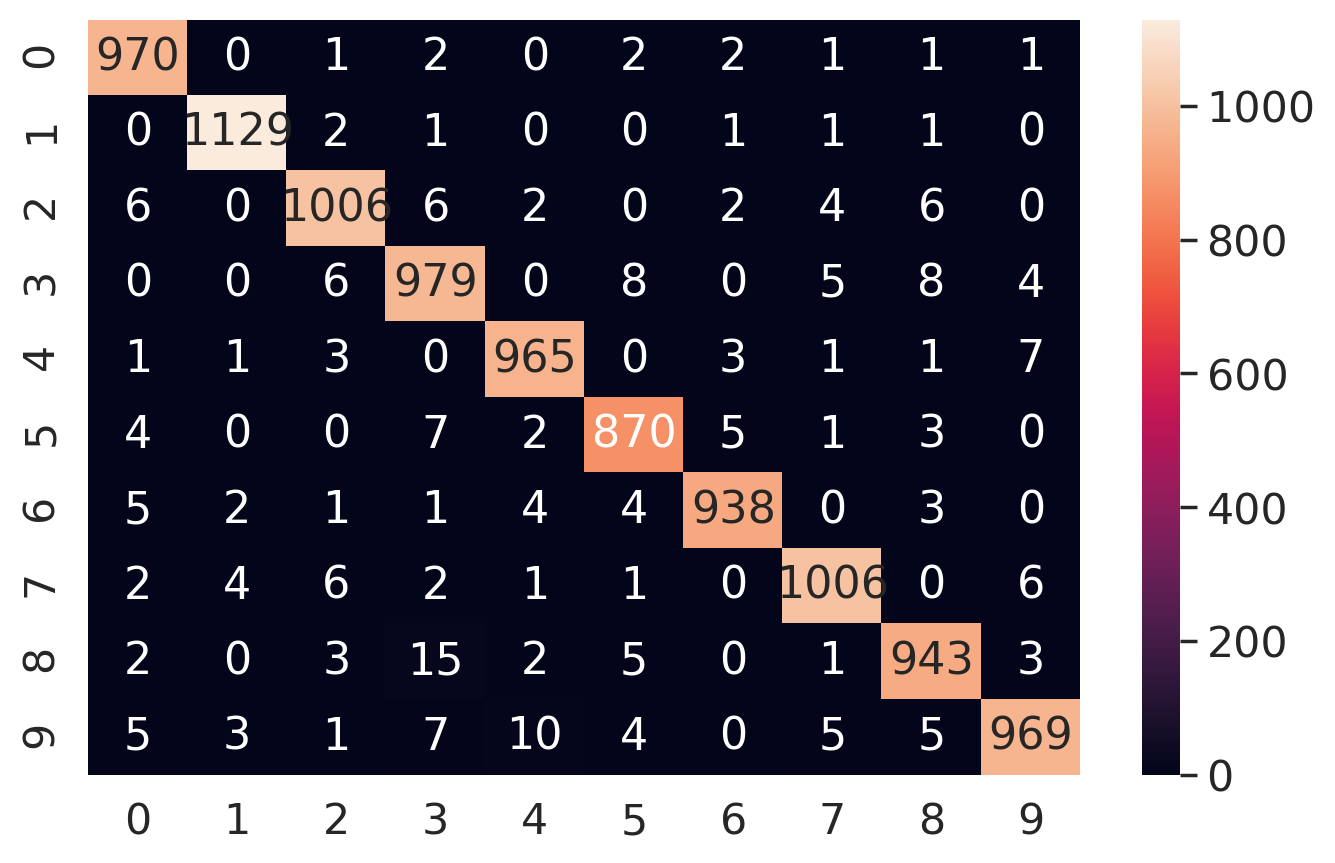

In [19]:
clf_confusion_matrix = confusion_matrix(y_test, predictions)
classes = [str(i) for i in range(10)]

df_cmatrix = pd.DataFrame(clf_confusion_matrix, classes, classes)
df_cmatrix.style.format("{:.1f}")


sn.set(font_scale=1.4) 
sn.heatmap(df_cmatrix, annot=True, annot_kws={"size": 16}, fmt='g')